In [199]:
### EDA on the human prefernce dataset 
# !pip install datasets

from datasets import load_dataset
dataset = load_dataset("lmarena-ai/arena-human-preference-55k")

print("Dataset structure:", dataset)

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie'],
        num_rows: 57477
    })
})


In [200]:
import pandas as pd
df = pd.DataFrame(dataset['train'])

In [201]:
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


### Token distribution analysis

In [209]:
import numpy as np

# Creating length columns
df['prompt_length'] = df['prompt'].str.len()
df['response_a_length'] = df['response_a'].str.len()
df['response_b_length'] = df['response_b'].str.len()

# Identify winner columns
def get_winning_response_length(row):
    if row['winner_model_a'] == 1:
        return len(row['response_a'])
    elif row['winner_model_b'] == 1:
        return len(row['response_b'])
    else:  # tie case
        return len(row['response_a'])  # or could average both responses

df['winner_length'] = df.apply(get_winning_response_length, axis=1)

# Calculate statistics for each type
def get_stats(series):
    return pd.Series({
        'mean': series.mean(),
        'median': series.median(),
        'std': series.std(),
        'min': series.min(),
        '25th': series.quantile(0.25),
        '75th': series.quantile(0.75),
        '90th': series.quantile(0.90),
        'max': series.max(),
        'count': series.count()
    })

# Get statistics for each category
prompt_stats = get_stats(df['prompt_length'])
response_a_stats = get_stats(df['response_a_length'])
response_b_stats = get_stats(df['response_b_length'])
winner_stats = get_stats(df['winner_length'])

# Combine all statistics into a single dataframe
all_stats = pd.DataFrame({
    'Prompt': prompt_stats,
    'Response': winner_stats
})

# Convert to tokens (approximate)
all_stats_tokens = all_stats / 4

print("\nApproximate token statistics:")
print(all_stats.round(2).to_string(float_format=lambda x: '{:.2f}'.format(x)))


Approximate token statistics:
         Prompt  Response
mean     369.20   1472.82
median    96.00   1188.00
std     1073.34   1579.88
min        7.00      4.00
25th      52.00    460.00
75th     243.00   1977.00
90th     784.00   2926.00
max    33056.00  54058.00
count  57477.00  57477.00


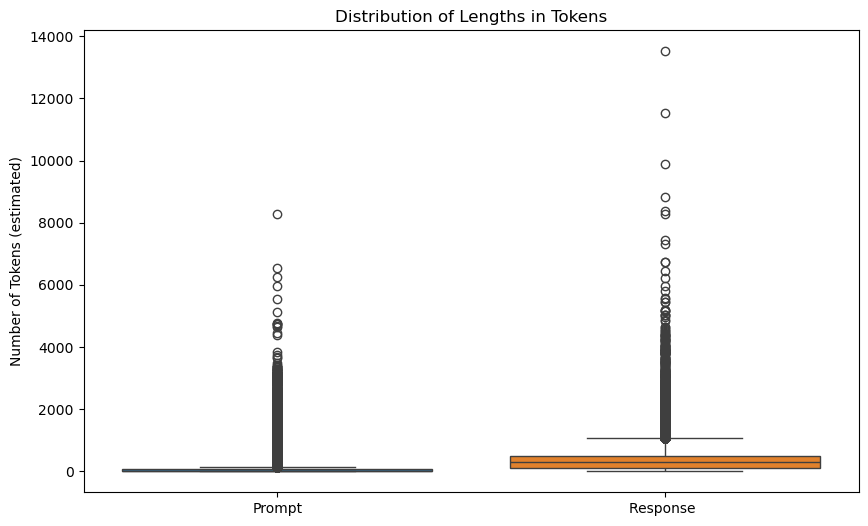

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert lengths to tokens (divide by 4)
prompt_tokens = df['prompt_length'] / 4
winner_tokens = df['winner_length'] / 4

plt.figure(figsize=(10, 6))
sns.boxplot(data=[prompt_tokens, winner_tokens])
plt.xticks(range(2), ['Prompt', 'Response '])
plt.title('Distribution of Lengths in Tokens')
plt.ylabel('Number of Tokens (estimated)')
plt.show()

### Looking at various models and calculating the win rates 

In [215]:
# Get unique values from both columns
all_unique_models = set(df['model_a'].unique()) | set(df['model_b'].unique())

print("All unique models:", list(all_unique_models))

All unique models: ['chatglm3-6b', 'falcon-180b-chat', 'claude-2.0', 'chatglm-6b', 'koala-13b', 'guanaco-33b', 'solar-10.7b-instruct-v1.0', 'vicuna-13b', 'gpt-4-0613', 'openchat-3.5-0106', 'RWKV-4-Raven-14B', 'chatglm2-6b', 'deepseek-llm-67b-chat', 'gemini-pro', 'llama2-70b-steerlm-chat', 'pplx-7b-online', 'qwen1.5-7b-chat', 'mpt-7b-chat', 'mistral-7b-instruct-v0.2', 'starling-lm-7b-alpha', 'gpt-3.5-turbo-1106', 'pplx-70b-online', 'wizardlm-70b', 'gpt-3.5-turbo-0125', 'qwen-14b-chat', 'tulu-2-dpo-70b', 'llama-2-70b-chat', 'gemini-pro-dev-api', 'gpt-4-0314', 'palm-2', 'claude-1', 'dolphin-2.2.1-mistral-7b', 'claude-2.1', 'vicuna-7b', 'dolly-v2-12b', 'stablelm-tuned-alpha-7b', 'qwen1.5-72b-chat', 'claude-instant-1', 'openhermes-2.5-mistral-7b', 'wizardlm-13b', 'codellama-34b-instruct', 'zephyr-7b-alpha', 'nous-hermes-2-mixtral-8x7b-dpo', 'gpt4all-13b-snoozy', 'mixtral-8x7b-instruct-v0.1', 'yi-34b-chat', 'stripedhyena-nous-7b', 'gpt-3.5-turbo-0613', 'zephyr-7b-beta', 'fastchat-t5-3b', 'al

In [30]:
# Calculate overall win rates per model
def calculate_win_rates():
    # Initialize dictionaries to store stats
    model_stats = {}
    # Process each row
    for _, row in df.iterrows():
        # Model A stats
        if row['model_a'] not in model_stats:
            model_stats[row['model_a']] = {'competed': 0, 'won': 0}
        model_stats[row['model_a']]['competed'] += 1
        if row['winner_model_a'] == 1:
            model_stats[row['model_a']]['won'] += 1
            
        # Model B stats
        if row['model_b'] not in model_stats:
            model_stats[row['model_b']] = {'competed': 0, 'won': 0}
        model_stats[row['model_b']]['competed'] += 1
        if row['winner_model_b'] == 1:
            model_stats[row['model_b']]['won'] += 1
    
    # Convert to DataFrame
    results = []
    for model, stats in model_stats.items():
        win_rate = (stats['won'] / stats['competed']) * 100
        results.append({
            'model': model,
            'total_competed': stats['competed'],
            'total_won': stats['won'],
            'win_rate': win_rate
        })
    
    return pd.DataFrame(results).sort_values('win_rate', ascending=False)

# Create head-to-head comparison matrix
def create_head_to_head_matrix():
    # Get all unique models
    all_models = list(set(df['model_a'].unique()) | set(df['model_b'].unique()))
    
    # Create empty matrix
    matrix = pd.DataFrame(0, index=all_models, columns=all_models)
    
    # Fill matrix with win rates
    for _, row in df.iterrows():
        model_a = row['model_a']
        model_b = row['model_b']
        
        if row['winner_model_a'] == 1:
            matrix.loc[model_a, model_b] += 1
        elif row['winner_model_b'] == 1:
            matrix.loc[model_b, model_a] += 1
    
    # Convert to percentages
    for model_a in all_models:
        for model_b in all_models:
            total_matches = matrix.loc[model_a, model_b] + matrix.loc[model_b, model_a]
            if total_matches > 0:
                matrix.loc[model_a, model_b] = (matrix.loc[model_a, model_b] / total_matches) * 100
                matrix.loc[model_b, model_a] = (matrix.loc[model_b, model_a] / total_matches) * 100
    
    return matrix

# Get overall win rates
win_rates_df = calculate_win_rates()
print("Overall Win Rates:")
print(win_rates_df)


Overall Win Rates:
                      model  total_competed  total_won   win_rate
0        gpt-4-1106-preview            7387       4073  55.137404
7        gpt-3.5-turbo-0314            1302        711  54.608295
29       gpt-4-0125-preview            1160        596  51.379310
9                gpt-4-0314            4122       1993  48.350315
25                 claude-1            3978       1747  43.916541
..                      ...             ...        ...        ...
38  stablelm-tuned-alpha-7b             771        132  17.120623
43                llama-13b             547         88  16.087751
15              chatglm3-6b             989        157  15.874621
31             dolly-v2-12b             800        124  15.500000
33              chatglm2-6b             564         73  12.943262

[64 rows x 4 columns]



Overall Win Rates:
                      model  total_competed  total_won win_rate
0        gpt-4-1106-preview            7387       4073    55.1%
7        gpt-3.5-turbo-0314            1302        711    54.6%
29       gpt-4-0125-preview            1160        596    51.4%
9                gpt-4-0314            4122       1993    48.4%
25                 claude-1            3978       1747    43.9%
..                      ...             ...        ...      ...
38  stablelm-tuned-alpha-7b             771        132    17.1%
43                llama-13b             547         88    16.1%
15              chatglm3-6b             989        157    15.9%
31             dolly-v2-12b             800        124    15.5%
33              chatglm2-6b             564         73    12.9%

[64 rows x 4 columns]


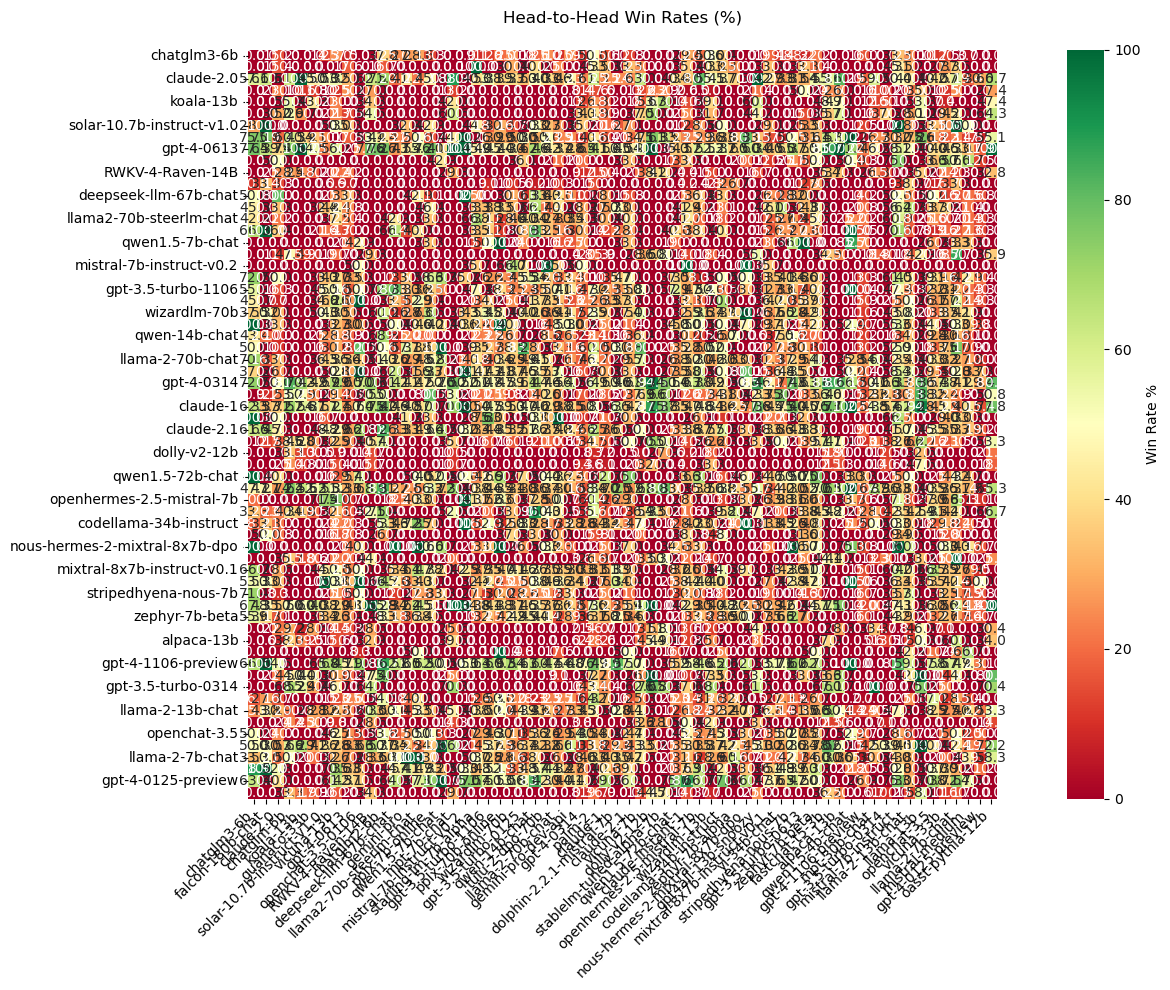


Head-to-head win rates:
                    chatglm3-6b  falcon-180b-chat  claude-2.0  chatglm-6b  \
chatglm3-6b                0.0%              0.0%       15.2%        0.0%   
falcon-180b-chat           0.0%              0.0%       15.4%        0.0%   
claude-2.0                57.6%             61.5%        0.0%       61.5%   
chatglm-6b                 0.0%              0.0%       23.1%        0.0%   
koala-13b                  0.0%              0.0%        0.0%       55.3%   
...                         ...               ...         ...         ...   
vicuna-33b                50.0%             50.0%       30.3%       57.9%   
llama-2-7b-chat           33.3%             50.0%       21.3%       50.0%   
mistral-medium            88.9%            100.0%       52.8%        0.0%   
gpt-4-0125-preview        63.6%              0.0%       40.0%        0.0%   
oasst-pythia-12b           0.0%              0.0%        0.0%       33.3%   

                    koala-13b  guanaco-33b  solar-

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_win_rates():
    model_stats = {}
    
    for _, row in df.iterrows():
        # Model A stats
        if row['model_a'] not in model_stats:
            model_stats[row['model_a']] = {'competed': 0, 'won': 0}
        model_stats[row['model_a']]['competed'] += 1
        if row['winner_model_a'] == 1:
            model_stats[row['model_a']]['won'] += 1
            
        # Model B stats
        if row['model_b'] not in model_stats:
            model_stats[row['model_b']] = {'competed': 0, 'won': 0}
        model_stats[row['model_b']]['competed'] += 1
        if row['winner_model_b'] == 1:
            model_stats[row['model_b']]['won'] += 1
    
    results = []
    for model, stats in model_stats.items():
        win_rate = (stats['won'] / stats['competed']) * 100
        results.append({
            'model': model,
            'total_competed': stats['competed'],
            'total_won': stats['won'],
            'win_rate': f"{win_rate:.1f}%"
        })
    
    return pd.DataFrame(results).sort_values('win_rate', ascending=False)

def create_head_to_head_matrix():
    all_models = list(set(df['model_a'].unique()) | set(df['model_b'].unique()))
    
    # Initialize matrix with float dtype
    matrix = pd.DataFrame(0.0, index=all_models, columns=all_models)
    matches = pd.DataFrame(0.0, index=all_models, columns=all_models)
    
    for _, row in df.iterrows():
        model_a = row['model_a']
        model_b = row['model_b']
        
        matches.loc[model_a, model_b] += 1
        matches.loc[model_b, model_a] += 1
        
        if row['winner_model_a'] == 1:
            matrix.loc[model_a, model_b] += 1
        elif row['winner_model_b'] == 1:
            matrix.loc[model_b, model_a] += 1
    
    # Convert to percentages where matches exist
    matrix = (matrix.div(matches) * 100).fillna(0)
    return matrix

# Get overall win rates
win_rates_df = calculate_win_rates()
print("\nOverall Win Rates:")
print(win_rates_df)

# Create and plot heatmap
matrix = create_head_to_head_matrix()
plt.figure(figsize=(15, 10))

# Create heatmap with improved readability
sns.heatmap(matrix, 
            annot=True, 
            cmap='RdYlGn',
            center=50, 
            fmt='.1f',
            square=True,
            cbar_kws={'label': 'Win Rate %'},annot_kws={'size': 8})

plt.title('Head-to-Head Win Rates (%)', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()


print("\nHead-to-head win rates:")
pd.set_option('display.float_format', '{:.1f}%'.format)
print(matrix)


Results for mistral-7b-instruct-v0.2:
                          opponent  total_matches  wins  win_rate
24                  tulu-2-dpo-70b              1     1     100.0
22  nous-hermes-2-mixtral-8x7b-dpo              1     1     100.0
8                 claude-instant-1              1     1     100.0
7                     wizardlm-70b              3     2      66.7
2                       gpt-4-0314              2     1      50.0
12               openchat-3.5-0106              2     1      50.0
1               gpt-3.5-turbo-0125             10     4      40.0
4       mixtral-8x7b-instruct-v0.1             14     5      35.7
9             starling-lm-7b-alpha             14     5      35.7
0                 llama-2-70b-chat             17     6      35.3
17                  mistral-medium              2     0       0.0
23              gpt-3.5-turbo-1106              1     0       0.0
21                      gpt-4-0613              2     0       0.0
20                      claude-2.1   

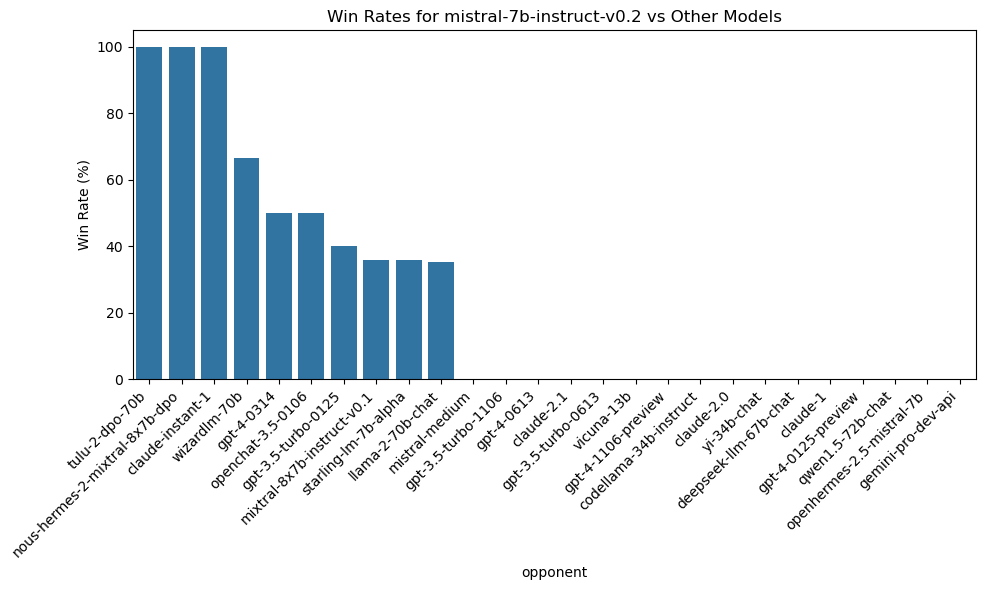

In [38]:
def get_model_comparisons(target_model):
    comparisons = []
    
    # Look through all matches involving the target model
    for _, row in df.iterrows():
        if row['model_a'] == target_model:
            opponent = row['model_b']
            won = row['winner_model_a'] == 1
            comparisons.append({'opponent': opponent, 'won': won})
        elif row['model_b'] == target_model:
            opponent = row['model_a']
            won = row['winner_model_b'] == 1
            comparisons.append({'opponent': opponent, 'won': won})
    
    # Calculate statistics per opponent
    results = {}
    for comp in comparisons:
        opponent = comp['opponent']
        if opponent not in results:
            results[opponent] = {'total': 0, 'wins': 0}
        results[opponent]['total'] += 1
        if comp['won']:
            results[opponent]['wins'] += 1
    
    # Convert to DataFrame
    df_results = pd.DataFrame([
        {
            'opponent': opponent,
            'total_matches': stats['total'],
            'wins': stats['wins'],
            'win_rate': (stats['wins'] / stats['total'] * 100)
        }
        for opponent, stats in results.items()
    ])
    
    return df_results.sort_values('win_rate', ascending=False)

# Get comparisons for the specific model
target_model = 'mistral-7b-instruct-v0.2'
results = get_model_comparisons(target_model)

print(f"\nResults for {target_model}:")
print(results.to_string(float_format=lambda x: '{:.1f}'.format(x)))

# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='opponent', y='win_rate')
plt.title(f'Win Rates for {target_model} vs Other Models')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Win Rate (%)')
plt.tight_layout()
plt.show()

In [39]:
total_matches = results['total_matches'].sum()
total_wins = results['wins'].sum()
overall_win_rate = (total_wins / total_matches * 100)
print(f"\nOverall statistics for {target_model}:")
print(f"Total matches: {total_matches}")
print(f"Total wins: {total_wins}")
print(f"Overall win rate: {overall_win_rate:.1f}%")


Overall statistics for mistral-7b-instruct-v0.2:
Total matches: 100
Total wins: 27
Overall win rate: 27.0%


### Look into MT-Bench i.e our eval set

In [43]:
from datasets import load_dataset
import random

mt_bench_eval = load_dataset("lmsys/mt_bench_human_judgments")

# Display some samples
def display_samples(dataset, n=5):
    print(f"\nDisplaying {n} random samples:")
    print("="*80)
    

    indices = random.sample(range(len(dataset['train'])), n)
    
    for idx in indices:
        sample = dataset['train'][idx]
        print("\nSample:", idx)
        print("-"*40)
        for key, value in sample.items():
            if isinstance(value, str) and len(value) > 500:
                print(f"{key}: {value[:500]}...")
            else:
                print(f"{key}: {value}")
        print("="*80)

In [44]:
mt_bench_eval

DatasetDict({
    gpt4_pair: Dataset({
        features: ['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn'],
        num_rows: 2400
    })
    human: Dataset({
        features: ['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn'],
        num_rows: 3355
    })
})

In [46]:
df_mt = pd.DataFrame(mt_bench_eval['human'])

In [216]:
df_mt.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn
0,81,alpaca-13b,gpt-3.5-turbo,model_b,author_2,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1
1,81,alpaca-13b,gpt-3.5-turbo,model_b,author_2,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2
2,81,alpaca-13b,gpt-3.5-turbo,model_b,expert_17,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1
3,81,alpaca-13b,gpt-3.5-turbo,model_b,expert_17,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2
4,81,alpaca-13b,vicuna-13b-v1.2,model_b,expert_0,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1


### Understanding the 50k dataset structure and debug the _prep_dataset bug

In [218]:
import os, random
from datasets import load_dataset

## Setting up the defaults
SEED       = int(os.environ.get("SEED", 42))
N_TRAIN    = int(os.environ.get("N_TRAIN", 5000)) 
N_EVAL     = int(os.environ.get("N_EVAL", 512))   
random.seed(SEED)

def _as_str_prompt(p):
    if isinstance(p, list):
        p = "\n".join([x for x in p if isinstance(x, str)])
    return (p or "").strip()


def _prep_datasets():
    """Normalize Arena-55k into prompt/chosen/rejected for DPO."""
    def make_prompt(p: str) -> str:
        return f"### Instruction:\n{_as_str_prompt(p)}\n\n### Response:\n"


    def normalize(ex):
        # 1) prompt
        p = ex.get("prompt", "")

        # 2) response text
        a_text = ex.get("response_a") or ""
        b_text = ex.get("response_b") or ""

        # 3) winner flags in this dataset
        wa = ex.get("winner_model_a", 0) or 0
        wb = ex.get("winner_model_b", 0) or 0
        wt = ex.get("winner_tie",     0) or 0

        # Coerce to booleans robustly
        try:
            wa = bool(int(wa))
        except Exception:
            wa = bool(wa)
        try:
            wb = bool(int(wb))
        except Exception:
            wb = bool(wb)
        try:
            wt = bool(int(wt))
        except Exception:
            wt = bool(wt)


        # 4) decide chosen/rejected based on flags (drop ties/ambiguous)
        if wa and not wb and not wt:
            chosen, rejected = a_text, b_text
        elif wb and not wa and not wt:
            chosen, rejected = b_text, a_text
        else:
            # tie or inconsistent flags -> mark empty so filter() removes it
            chosen = rejected = ""

        return {"prompt": make_prompt(p), "chosen": chosen, "rejected": rejected}


    def ok(ex):
        # ensure non-empty instruction body + non-empty, non-identical responses
        before_resp = ex["prompt"].split("### Response:")[0]
        core = before_resp.replace("### Instruction:", "", 1).strip()
        return bool(core and ex["chosen"].strip() and ex["rejected"].strip() and (ex["chosen"].strip() != ex["rejected"].strip()))

    ds = load_dataset("lmarena-ai/arena-human-preference-55k")
    # This dataset only has a 'train' split; map + filter it
    train_only = ds["train"].map(normalize, remove_columns=ds["train"].column_names).filter(ok)

    # Create a small eval split from the cleaned train
    split = train_only.train_test_split(test_size=0.02, seed=SEED)

    train_ds = split["train"].select(range(min(N_TRAIN, len(split["train"])))) if N_TRAIN > 0 else split["train"]
    eval_ds  = split["test"].select(range(min(N_EVAL,  len(split["test"]))))  if N_EVAL  > 0 else None
    return train_ds, eval_ds


# ---- Run + quick checks
train_ds, eval_ds = _prep_datasets()
print(train_ds)
print(eval_ds)

expected_cols = {"prompt", "chosen", "rejected"}
assert set(train_ds.column_names) == expected_cols, f"Train columns mismatch: {train_ds.column_names}"
if eval_ds is not None:
    assert set(eval_ds.column_names) == expected_cols, f"Eval columns mismatch: {eval_ds.column_names}"
print("Columns OK (prompt/chosen/rejected).")


# Peek samples to confirm we see actual responses (not model names which was the bug earlier) and a clean prompt
def show_examples(ds, k=2, seed=SEED):
    for ex in ds.shuffle(seed=seed).select(range(k)):
        print("="*80)
        print(ex["prompt"])
        print("--- chosen (first 400 chars) ---")
        print(ex["chosen"][:400])
        print("--- rejected (first 400 chars) ---")
        print(ex["rejected"][:400])


print("\nTrain samples:")
show_examples(train_ds, k=2)
if eval_ds is not None:
    print("\nEval samples:")
    show_examples(eval_ds, k=2)


#count how many rows we kept and that ties are excluded
print(f"\nKept rows: train={len(train_ds)}, eval={0 if eval_ds is None else len(eval_ds)}")

Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

Filter:   0%|          | 0/57477 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 5000
})
Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 512
})
Columns OK (prompt/chosen/rejected).

Train samples:
### Instruction:
["hello, I am the chair of a grotto. What does that mean?"]

### Response:

--- chosen (first 400 chars) ---
["Hello! As the chair of a grotto, it means you hold a leadership position within a local caving organization or a chapter of a larger caving association. A grotto is a term used for a group of cavers, generally dedicated to the exploration, conservation, and study of caves. As the chair, you would be responsible for overseeing meetings, organizing events, coordinating with other members, and ensu
--- rejected (first 400 chars) ---
["The term \"grotto chair\" refers to a type of furniture that originated during the 18th and 19th centuries, when European nobility built shell-encrusted pavilions and grottos. These chairs are characterized by their shell-fo

In [217]:
# Sanity test the method
# 1) For 20 random raw rows, verify we pick the right side

from datasets import load_dataset
import random, json

raw = load_dataset("lmarena-ai/arena-human-preference-55k")["train"]
idxs = random.sample(range(len(raw)), 20)

def as_text(x):
    if isinstance(x, list): return "\n".join(s for s in x if isinstance(s,str)).strip()
    if isinstance(x, str) and x.strip().startswith("[") and x.strip().endswith("]"):
        try:
            arr = json.loads(x)
            if isinstance(arr, list): return "\n".join(str(t) for t in arr).strip()
        except Exception:
            pass
    return "" if x is None else str(x).strip()


mismatches = 0
ties = 0
for i in idxs:
    ex = raw[i]
    a = as_text(ex["response_a"]); b = as_text(ex["response_b"])
    wa = bool(int(ex["winner_model_a"] or 0)); wb = bool(int(ex["winner_model_b"] or 0)); wt = bool(int(ex["winner_tie"] or 0))
    if wt or (wa and wb): ties += 1; continue
    chosen = a if wa else b if wb else ""
    rejected = b if wa else a if wb else ""
    if not chosen or not rejected or chosen == rejected:
        mismatches += 1


print("mismatches:", mismatches, "| ties:", ties)

# After _prep_datasets(), assert the shape/fields and that ties were dropped
train_ds, eval_ds = _prep_datasets()
assert set(train_ds.column_names) == {"prompt","chosen","rejected"}
assert all(x["chosen"] != x["rejected"] for x in train_ds.select(range(min(500, len(train_ds)))))
print("Dataset contract looks good:", train_ds, eval_ds)

mismatches: 0 | ties: 10
Dataset contract looks good: Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 5000
}) Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 512
})
